# SpaGFT Toturial

## Outline
1. Installation
2. import module
3. Load data and preprocessing
4. Detect spatially variable genes
5. Detect tissue modules
6. Impute gene expressions

## 1. Install
SpaGFT is a python package to analysis spatial transcriptomics data. To install SpaGFT, the python version is requried to >= 3.7. You can check your python version by:

In [1]:
import platform
platform.python_version()

'3.8.0'

We recommend you create a virtual environment for running SpaGFT. You achieve this by conda easily:
```shell
conda create -n spagft python==3.8.0
conda activate spgft
```
If you want to exit this virtual envrionment, just run:
```shell
conda deactivate
```
Next, install SpaGFT by
```shell
git colne url
cd dir
conda install requiremnt.txt
python3 setup.py build
python3 setup.py install
```

## 2. import module


In [2]:
import SpaGFT.gft as gft
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib.pyplot as plt

Here, we use a spatial transcriptomcis data generated from human brain.

## 3. Load Data and preprocessing

In [3]:
# Define data path
data_path = './datasets/151673'

In [4]:
# Load data
adata = sc.read_visium(data_path)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

__Note__ that two elements are requried, that are, count matrix and spatial information. Here, count matrix is generated by ```adata.X``` while ```adata.obs[spatial_names]``` provides spatial information.

In [6]:
# Pre-processing
adata.var_names_make_unique()
## QC
sc.pp.filter_genes(adata, min_cells=10)
# Normalization
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

## 4. Detect spatially variable genes

In [7]:
gene_rank = gft.rank_gene_smooth(adata, spatial_names=['array_row', 'array_col'])

Graph Fourier Transform finished!
SVG ranking could be found in adata.obs['Rank']
Gene signals in frequency domain could be found in           adata.varm['freq_domain']


If you want to utilize other spatial information in adata.uns[spatial_keys], such as pixel information, SpaGFT also provides other spatial information choise.  

For example,  

```python
gene_rank = gft.rank_gene_smooth(adata, spatial_keys='spatial')
```


In [8]:
gene_rank.iloc[:5, :]

,gft_score,svg_rank
PLP1,3.861359,1
MBP,3.751655,2
MOBP,3.733573,3
MT-CO1,3.674513,4
TF,3.665567,5


... storing 'feature_types' as categorical
... storing 'genome' as categorical


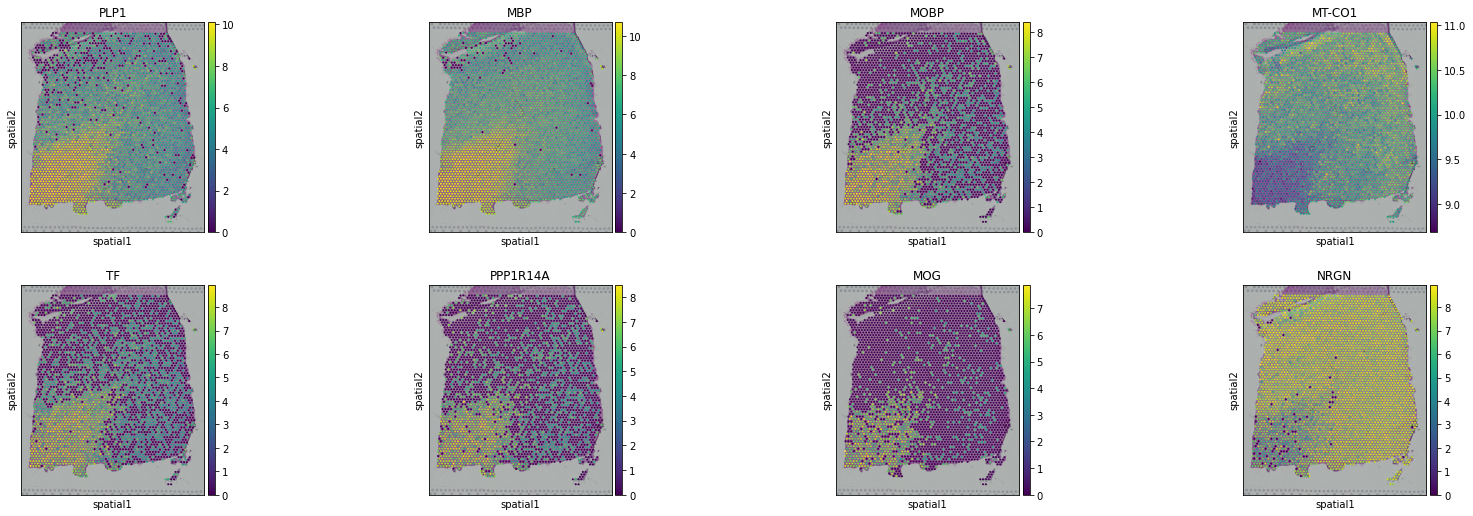

In [9]:
# visualizaiton
sc.pl.spatial(adata, color=gene_rank.index[:8])

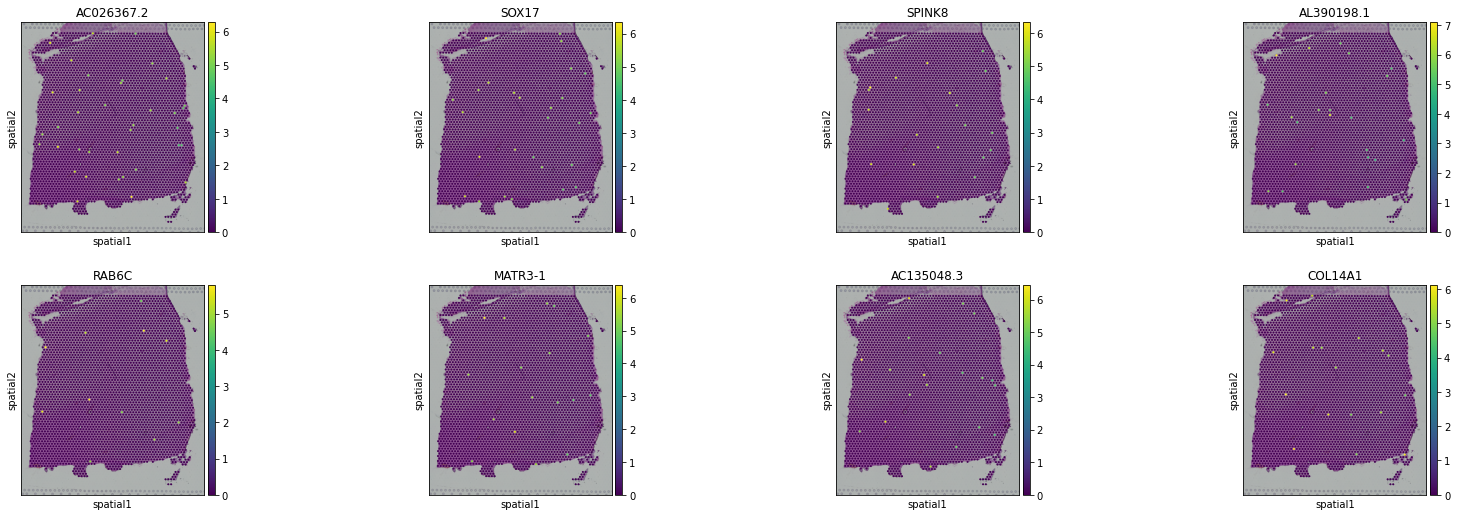

In [10]:
# Non-SVG
sc.pl.spatial(adata, color=gene_rank.index[-8:])

## 5. Detect tissue modules

SpaGFT could detect tissue modules by groupying spatially variable genes with similar spatial patterns. The gene signals in frequency domain could be found by ```adata.varm['freq_domain']```, whose rows indicate genes while columns indicate various frequencies Fourier modes.

In [11]:
adata.varm['freq_domain']

array([[1.99857850e-07, 8.22585009e-03, 1.12772824e-02, ...,
        7.93424975e-03, 1.82282502e-02, 7.68936858e-03],
       [2.21922670e-09, 3.74488673e-02, 8.12901148e-03, ...,
        4.67506414e-03, 8.94201664e-03, 1.47954700e-02],
       [1.95621095e-07, 2.58500592e-02, 1.65442445e-03, ...,
        1.39967405e-02, 2.27827743e-02, 2.28254920e-02],
       ...,
       [1.86405035e-07, 1.46723307e-02, 1.66665499e-02, ...,
        7.70570052e-03, 7.53634400e-03, 5.75042765e-03],
       [6.26629475e-08, 1.11174862e-01, 1.35793998e-02, ...,
        9.26947895e-03, 4.47664702e-03, 4.19584925e-03],
       [3.53159660e-07, 4.45406699e-02, 2.81741336e-02, ...,
        5.07726333e-03, 1.32644352e-02, 2.47801476e-02]])

In [24]:
# tissue_module
tm_info = gft.find_tissue_module(adata, n_genes=500, resolution=2)
tm_info[:5]

PLP1      4
MBP       4
MOBP      4
MT-CO1    8
TF        4
Name: louvain, dtype: category
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']

... storing 'tm_gene_group' as categorical


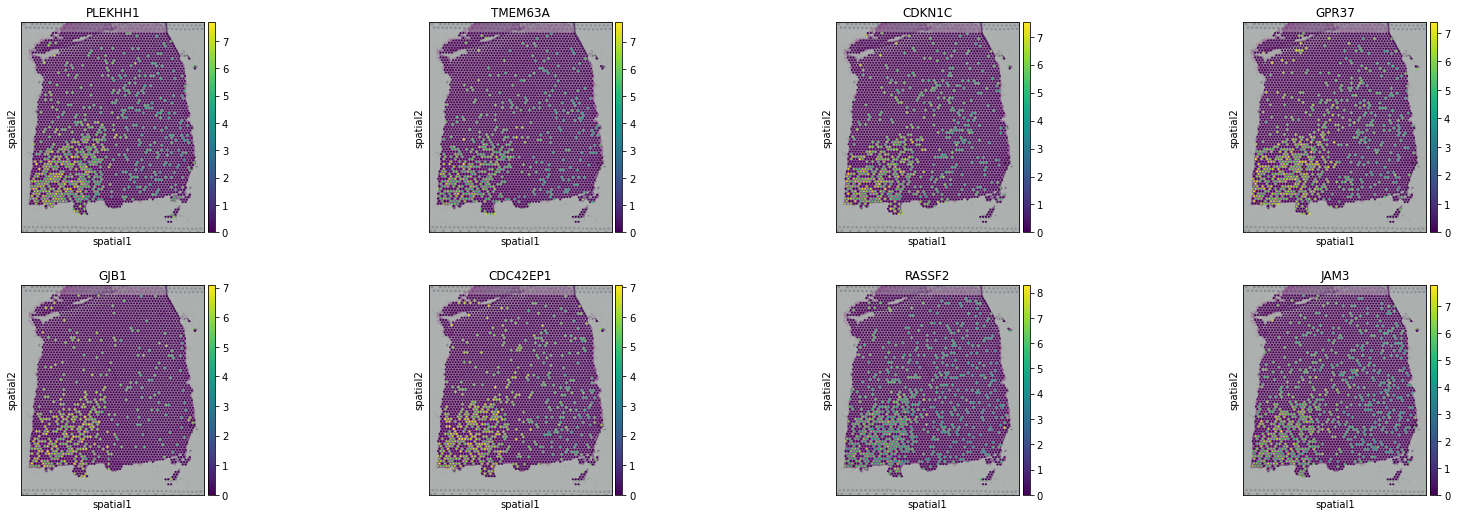

In [25]:
# visualization
sc.pl.spatial(adata, color=tm_info[tm_info == '0'].index[:8])

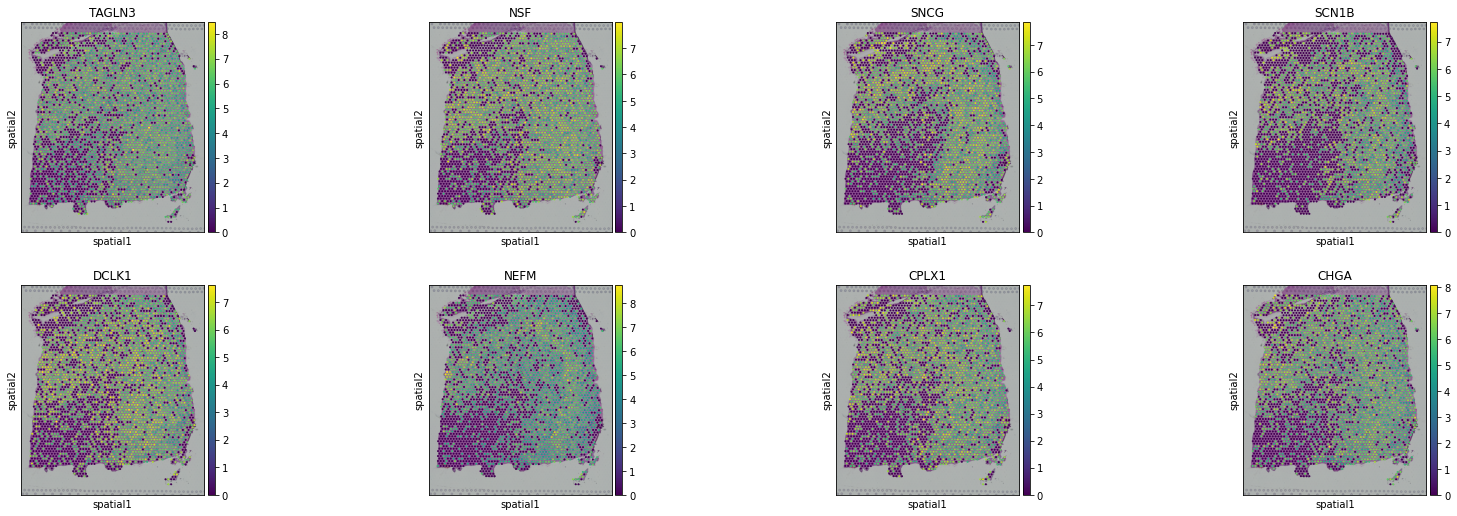

In [26]:
sc.pl.spatial(adata, color=tm_info[tm_info == '1'].index[:8])

## 6. Impute gene expressions

In [43]:
adata = sc.read_visium(data_path)
# Pre-processing
adata.var_names_make_unique()
## QC
sc.pp.filter_genes(adata, min_cells=10)
# Normalization
sc.pp.normalize_total(adata, target_sum=1e6)
tmp_adata = adata[:, gene_rank.index[:2000]]
new_count_mtx = gft.low_frequency_filter(tmp_adata, c=1)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... storing 'feature_types' as categorical
... storing 'genome' as categorical


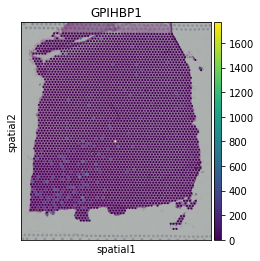

In [44]:
# Before
sc.pl.spatial(adata, color=gene_rank.index[100])

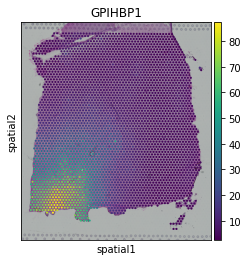

In [45]:
# After
adata[:, gene_rank.index[100]] = new_count_mtx.loc[:, gene_rank.index[100]]
sc.pl.spatial(adata, color=gene_rank.index[100])